# ANN Local Fit

Overview:

1. Start with a specific set of kinematic variables.  
2. Initialize a ANN with 4 Kins as input and 3 CFFs as output
3. Pick random starting points for each parameter in ANN
4. Input data to ANN (using current params) to produce Fs
5. Compare resulting Fs to sampled Fs and compute mean squared error
6. Update ANN params in a direction that reduces that mean squared error
7. Repeat steps 3-5 until loss changes only very slightly

The autoreloader enables you to make edits in imported files and those edits will become immediately available.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts #general utilities that are useful for all methods

## General global variable definitions

In [5]:
bhdvcs = BHDVCS()
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

numSets = 15
numReplicas = 30

## Define and compile model

This makes use of the tensorflow [functional api](https://www.tensorflow.org/guide/keras/functional)

In [6]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = uts.TotalUUXSlayer()(totalUUXSInputs) # incorporate cross-sectional function

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

In [7]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [8]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(.02),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [9]:
Wsave = globalModel.get_weights()

## Produce CFFdists

In [10]:
print(Wsave[0])

[[ 0.10500586  0.02962637 -0.11063504 -0.06324375  0.4228207   0.22429013
  -0.4156437   0.3358115  -0.3015585   0.35034359  0.24337208  0.3936962
  -0.22107863 -0.06140161  0.0136528  -0.03828096 -0.48366344  0.02780104
  -0.3345132   0.3682102 ]
 [-0.03742194 -0.12208796 -0.32137728  0.1278317   0.21782756  0.30130935
  -0.44785058 -0.40776563  0.27284813 -0.05791891 -0.09321117 -0.0374738
  -0.1916604  -0.18264747 -0.33579898  0.0227567   0.05909586 -0.32400596
  -0.48625565  0.40233052]
 [ 0.289348   -0.25668025  0.03971899 -0.0105803   0.271932   -0.453133
  -0.4338956   0.32534552  0.33562946  0.3338884  -0.06645     0.26873624
   0.17482626  0.40924156 -0.00939047 -0.06626844  0.47182357  0.05481207
   0.0577513  -0.03669798]
 [-0.20786917  0.31024015  0.3807485  -0.29154885 -0.13256383  0.00974596
   0.02027905  0.4000051   0.14239728 -0.47902036  0.38482976  0.21141982
   0.148808    0.17182124  0.00089824 -0.39239419 -0.10063493 -0.36735296
  -0.38254964  0.11169338]]


In [12]:
def produceCFFs(numReplicas, data, Wsave):
    '''
    :param numSamples: number of replicas to produce
    :param data: whole DvcsData
    :param Wsave: saved weights
    
    :returns: numpy array of shape (numSets, numReplicas, 3)
    '''

    by_sample = []

    for i in tqdm(range(max(data.df['#Set'])+1)):

        globalModel.set_weights(Wsave) # reset weights to original value

        setI = data.getSet(i) #DvcsData object containing specific set

        by_set = []

        for sample in range(numReplicas):
            
            #this callback enables us to roll the network back to its minimum loss during training
            
            globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # the sample Y will generate Fs
                        epochs=100, verbose=1)

            #globalModel.load_weights(chkpt_path) # load back minimum loss epoch

            cffs = uts.cffs_from_globalModel(globalModel, setI.Kinematics) # get cffs from middle model

            by_set.append(cffs)

        by_sample.append(by_set)
        
    return np.array(by_sample)

This took about 2 hours to run

In [13]:
results = produceCFFs(5, data, Wsave)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/100
2/2 [==============================] - 6s 3ms/step - loss: 0.0061
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 4.4987e-04
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 1.3451e-04
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 4.0367e-04
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 5.4928e-04
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 4.8741e-04
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 3.1644e-04
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 1.5388e-04
Epoch 10/100
2/2 [==============================] - 0s 2ms/step - loss: 8.5123e-05
Epoch 11/100
2/2 [==============================] - 0s 2ms/step - loss: 1.0097e-04
Epoch 12/100
2/2 [==============================] - 0s 3ms/step - loss: 1.5064e-04
Epoch 13/100
2/2 [===

# ReH

In [14]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  1057.7887034745609
RMSE:  8.614994837297557
RMSE w yhat=mean:  2.5254628436780098
R-squared:  -10.636652798799403


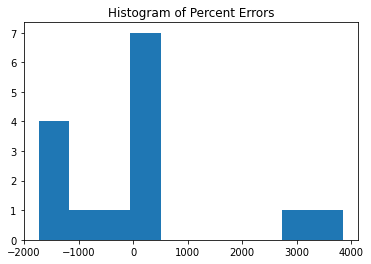

In [15]:
uts.evaluate(y_yhat)

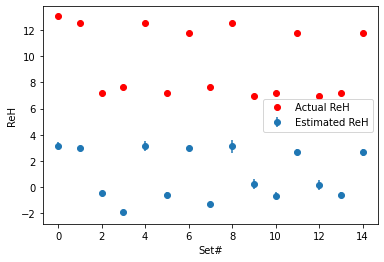

In [16]:
uts.plotError(y_yhat, err, "ReH")

# ReE

In [17]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)

Mean percent error:  4137.996047133681
RMSE:  47.32721780482327
RMSE w yhat=mean:  2.525480507907797
R-squared:  -350.18334200615095


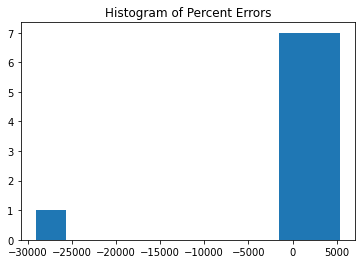

In [18]:
uts.evaluate(y_yhat)

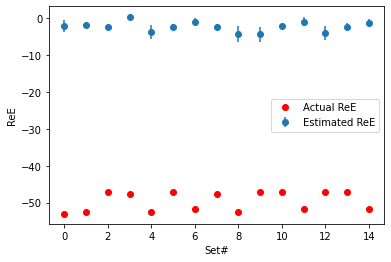

In [19]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  685.4907124222332
RMSE:  3.080084845989348
RMSE w yhat=mean:  1.4030345621243818
R-squared:  -3.819351702639927


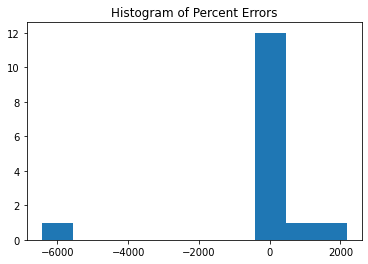

In [20]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

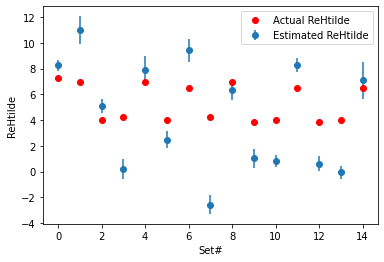

In [21]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Mean percent error:  10.886941704952921
RMSE:  0.0036453987631953747
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.9471406292063902


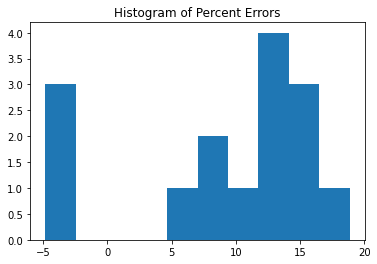

In [22]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

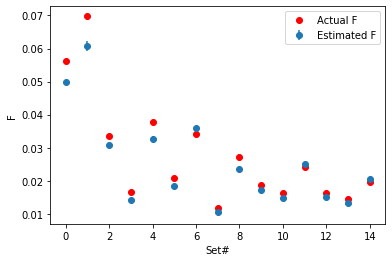

In [23]:
uts.plotError(y_yhat, err, "F")